In [1]:
# this notebook should be run in Google Colab
# matplotlib and seaborn used for plotting graphs

import json
import requests
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
# you can retrieve BTC data using cryptocompare api as I did
# here I will use already retrieved csv file containing the BTC information of the last 1000 days

df = pd.read_csv("btc.csv", parse_dates = True, index_col=0)
df.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-11-06 15:16:30.932203,6959.23,7429.70,6934.73,7389.55,159688.48,1.148125e+09
2017-11-07 15:16:30.932203,7102.75,7222.37,6957.80,6959.27,101044.57,7.167984e+08
2017-11-08 15:16:30.932203,7444.36,7869.10,7026.97,7102.23,220224.38,1.632547e+09
2017-11-09 15:16:30.932203,7129.59,7457.12,7040.83,7444.36,126769.90,9.159639e+08
2017-11-10 15:16:30.932203,6565.80,7318.97,6406.05,7129.59,222001.18,1.513421e+09


In [3]:
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [4]:
train, test = train_test_split(df, test_size=0.3)

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

time
2019-10-08 15:16:30.932203     8191.87
2019-10-09 15:16:30.932203     8593.16
2019-10-10 15:16:30.932203     8596.57
2019-10-11 15:16:30.932203     8278.05
2019-10-12 15:16:30.932203     8316.66
                                ...   
2020-07-29 15:16:30.932203    11112.04
2020-07-30 15:16:30.932203    11113.66
2020-07-31 15:16:30.932203    11352.72
2020-08-01 15:16:30.932203    11812.42
2020-08-02 15:16:30.932203    11139.01
Name: close, Length: 300, dtype: float64


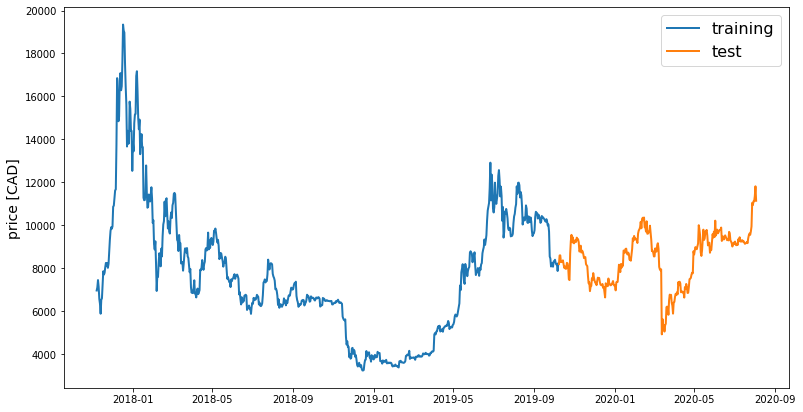

In [6]:
line_plot(train['close'], test['close'], 'training', 'test', title='')
print(test['close'])

Text(0, 0.5, 'BTC closing value')

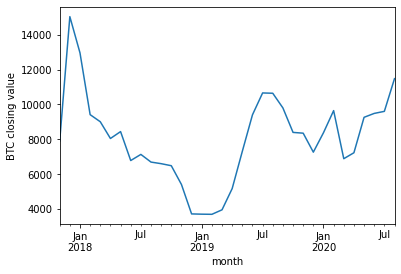

In [7]:
# plot monthly data

df.close.resample('M').mean().plot()
plt.xlabel ("month")
plt.ylabel("BTC closing value")

In [8]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [9]:
def extract_window_data(df, window_len = 7, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [10]:
def prepare_data(df, target_col, window_len = 7, zero_base=True, test_size=0.3):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [11]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [12]:
# you can try different parameters if you want

random.seed(42)
window_len = 7
test_size = 0.3
zero_base = True
lstm_neurons = 500
epochs = 300
batch_size = 256
loss = 'mean_squared_error'
dropout = 0.05
optimizer = 'adam'

In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, 'close', window_len=window_len, zero_base=zero_base, test_size=test_size)

In [14]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Epoch 1/300
3/3 [==============================] - 4s 649ms/step - loss: 0.0189 - val_loss: 0.0166
Epoch 2/300
3/3 [==============================] - 1s 301ms/step - loss: 0.0156 - val_loss: 0.0041
Epoch 3/300
3/3 [==============================] - 1s 299ms/step - loss: 0.0071 - val_loss: 0.0082
Epoch 4/300
3/3 [==============================] - 1s 299ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 5/300
3/3 [==============================] - 1s 309ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 6/300
3/3 [==============================] - 1s 300ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 7/300
3/3 [==============================] - 1s 304ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 8/300
3/3 [==============================] - 1s 300ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 9/300
3/3 [==============================] - 1s 298ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 10/300
3/3 [==============================] - 1s 302ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 11/

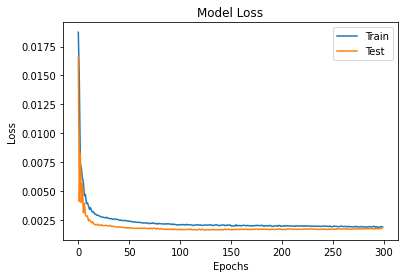

In [15]:
def loss_function(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.show()

history.history.keys
loss_function(history)

In [16]:
# cross-validation gives good-enough results
# calculate the error between the predicted values and the test set values

targets = test['close'][window_len:]
preds = model.predict(X_test).squeeze()
print('error is ' + str(mean_absolute_error(preds, y_test)*100) + ' %')

error is 2.7924037695308797 %


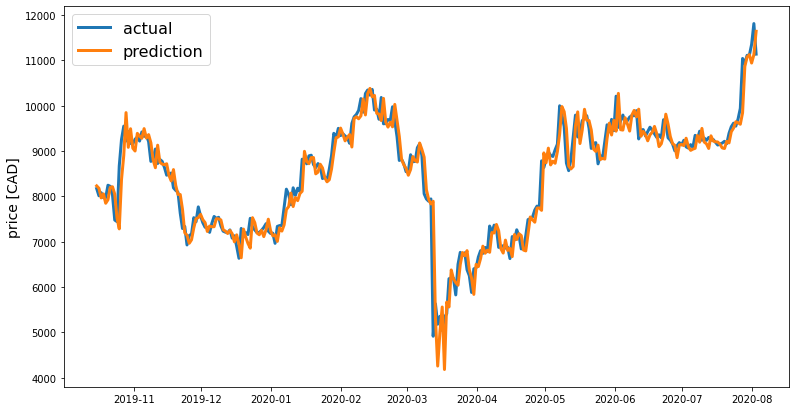

In [17]:
preds = test['close'].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)